## Capstone Project: Toxic Comment Classification

---

In this notebook, 

---
### Dataset

The Movie Review Dataset is a collection of movie reviews retrieved from the imdb.com website in the early 2000s by Bo Pang and Lillian Lee. The reviews were collected and made available as part of their research on natural language processing. The dataset can be downloaded from here:

* Movie Review Polarity Dataset (review polarity.tar.gz, 3MB).
  https://goo.gl/L6ZsLv

The dataset is comprised of 1,000 positive and 1,000 negative movie reviews drawn from an archive of the rec.arts.movies.reviews newsgroup hosted at IMDB. The authors refer to this dataset as the “polarity dataset“. The data has been cleaned up somewhat, for example:

* The dataset is comprised of only English reviews.
* All text has been converted to lowercase.
* There is white space around punctuation like periods, commas, and brackets.
* Text has been split into one sentence per line.


From this dataset, I will develop a sentiment analysis deep learning model to predict whether a given movie review is positive or negative.

### Outline

The notebook is divided into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Data
* [Step 1](#step1): Data Exploration and Exploratory Visualization
* [Step 2](#step2): Data Preprocessing
* [Step 3](#step3): Logistic Regression Classifier (Benchmark)
* [Step 4](#step4): Use a CNN to Classify Movie Review (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Movie Review (using Transfer Learning)
* [Step 6](#step6): Write 
* [Step 7](#step7): Test 

---
<a id='step0'></a>
## Step 0: Import Data

### Import Movie Review Dataset

In the code cell below, I import a dataset of IMDB movie reviews. I will look at loading individual text files, then processing the directories of files. A few variables has been populated through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [166]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
from nltk.corpus import stopwords

#settings
color = sns.color_palette()
sns.set_style("whitegrid")
stopwords_eng = set(stopwords.words("english"))


In [159]:
# load text data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('Trainning set contains {} records and testing set contains {} records.'.format(len(train),len(test)))

Trainning set contains 159571 records and testing set contains 153164 records.


---
<a id='step1'></a>
## Step 1: Data Exploration and Exploratory Visualization

### Inspect Dataset

Inspect a few lines. There are 8 columns. The first column is 'id', the second column is the 'comment text' and the following six columns are labels of the toxicity (1 for toxic, 0 for non-toxic).

In [13]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [161]:
# class imbalance
labels = train.iloc[:,2:8]
row_sum = labels.sum(axis = 1)
# mark comments without any labels as "clean"
train['clean'] = (row_sum == 0)
print('Total comments is {}.'.format(len(train)))
print('The clean comments is {}, which is {} of total comments.'.format(train['clean'].sum(),train['clean'].sum()/len(train)))

Total comments is 159571.
The clean comments is 143346, which is 0.8983211235124177 of total comments.


In [282]:
# check for missing values in the trainning set
missing_train = train.isnull().sum()
missing_test = test.isnull().sum()
missing_train, missing_test

(id               0
 comment_text     0
 toxic            0
 severe_toxic     0
 obscene          0
 threat           0
 insult           0
 identity_hate    0
 clean            0
 dtype: int64, id              0
 comment_text    0
 dtype: int64)

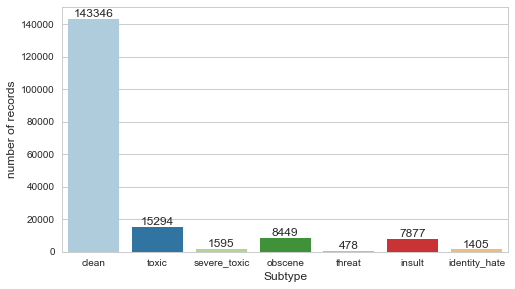

In [283]:
# plot different types of labels
column_sum = pd.Series(labels.sum(axis = 0))
clean = pd.Series(train['clean'].sum(), index = ['clean'])
# add clean document amount as a new type
column_sum = pd.concat([clean, column_sum])

# barplot for different labels
plt.figure(figsize=(8,4.5))
ax = sns.barplot(column_sum.index, column_sum.values, palette = "Paired")
plt.xlabel('Subtype', fontsize = 12)
plt.ylabel('number of records', fontsize = 12)

# add the text labels
for rect, label in zip(ax.patches, column_sum.values):
        ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), label,ha = 'center', va='bottom')

# save the figure as .eps file
fig_subtype = ax.get_figure()
fig_subtype.savefig('figure/subtype.eps')
plt.show()

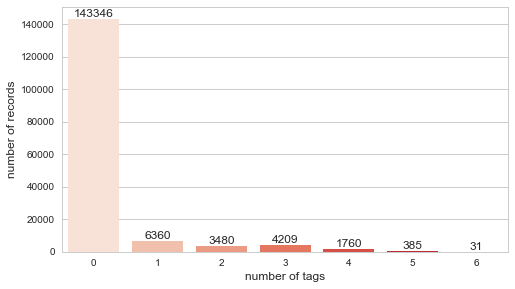

In [284]:
multi_tags = [ sum(row_sum == i) for i in range(7)]
multi_tags = pd.Series(multi_tags, index = [0,1,2,3,4,5,6])
plt.figure()
color_reds = sns.color_palette("Reds", n_colors=7, desat=1)

# barplot for different labels
plt.figure(figsize=(8,4.5))
ax_1 = sns.barplot(multi_tags.index, multi_tags.values, palette = color_reds)
plt.xlabel('number of tags', fontsize = 12)
plt.ylabel('number of records', fontsize = 12)

# add the text labels
for rect, label in zip(ax_1.patches, multi_tags.values):
        ax_1.text(rect.get_x() + rect.get_width()/2, rect.get_height(), label,ha = 'center', va='bottom')
        
# save the figure as .eps file
fig_multi_tags = px.get_figure()
fig_multi_tags.savefig('figure/multi_tags.eps')
plt.show()

In [251]:
# multi-tagging
multi_tags = [ sum(row_sum == i) for i in range(7)]
multi_tags = pd.Series(multi_tags, index = [0,1,2,3,4,5,6])
plt.figure()
color_reds = sns.palplot(sns.light_palette("red"))
multi_tags
sns.barplot(multi_tags.index, multi_tags.values, palette = sns.palplot(sns.light_palette("red"))

##bar_plot_label(multi_tags.index, multi_tags.values,'number of tags', 'number of records', color_reds,'figure/multi_tags.eps')

SyntaxError: unexpected EOF while parsing (<ipython-input-251-e82dab8568fc>, line 9)

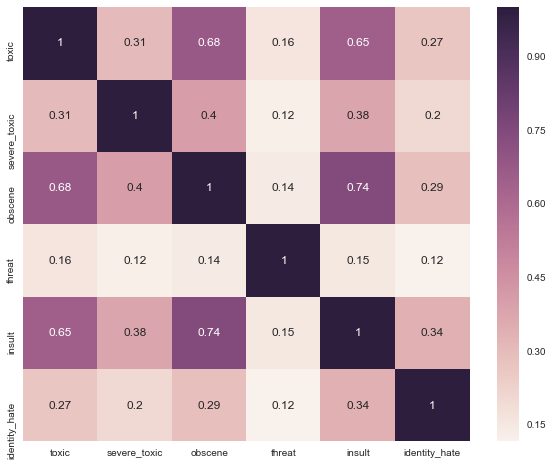

In [70]:
# correlation between subtypes
corr = train.iloc[:,2:8].corr()
plt.figure(figsize = (10,8))
corr_plot = sns.heatmap(corr, annot = True)
plt.show()
# save the figure
fig_corr = corr_plot.get_figure()
fig_corr.savefig('figure/correlation.eps')

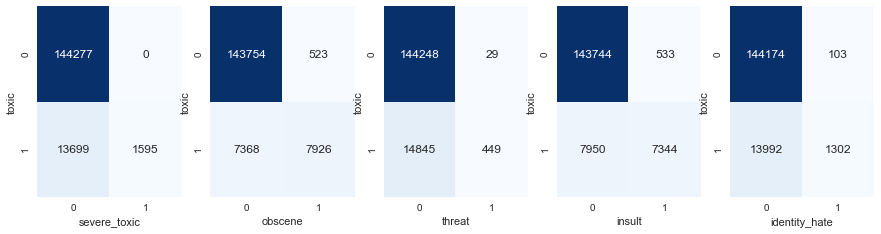

In [237]:
# crosstab
subtypes = ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
i = 1
plt.figure(figsize = (15,3.5))
for subtype in subtypes:
    plt.subplot(1,5,i)
    cross = sns.heatmap(pd.crosstab(train['toxic'],train[subtype]),annot = True, fmt = '', cbar = False, cmap = "Blues")
    i += 1
plt.show()  
fig_cross = cross.get_figure()
fig_cross.savefig('figure/crosstab.eps')

In [241]:
all_types = ['clean', 'toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for t in all_types:
    record_number = random.randint(1, train[t].sum())
    print('The {}th record of "{}" comments is:'.format(record_number,t))
    print(train[train[t] == 1].iloc[record_number,1])
    print('')
    

The 126104th record of "clean" comments is:
"

You say you ""received his approval"", but for what? To license under GFDL? To license under a version of Creative Commons? To put in the public domain? We must use one of the standard licenses, because they cover all the legal angles, such as commercial use in printed version of WP. Just a ""permission to use in WP"" is completely insufficient.  "

The 2197th record of "toxic" comments is:
What the hell is wrong with this thing ? why are my changes not showing?

The 1087th record of "severe_toxic" comments is:
@Qwyrxian suck my dick

The 4812th record of "obscene" comments is:
stupid fucking volcano

The 115th record of "threat" comments is:
Please go and kill yourself. You clearly have nothing better to do on wikipedia than try and fuck it up for other people. We have no need for your kind.  (talk)

The 5786th record of "insult" comments is:
hey Jingiby you hate Turkic people because you are a racist Slavic Bulgarian... but you hate your

In [230]:
# frequent words 
def wordcloud_generator(subtype, background, mask_file):
    subset = train[train[subtype] == True]
    subset_text = subset.comment_text.values
    # import mask file
    mask = np.array(Image.open(mask_file))
    mask = mask[:, :, 1]
    # create a wordcloud for the text 
    wordcloud = WordCloud(background_color = background, mask = mask, stopwords = stopwords_eng)
    wordcloud.generate(" ".join(subset_text))    
    return wordcloud

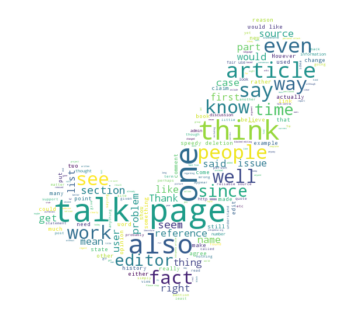

In [239]:
# wordcloud plot for clean comments
wordcloud_clean = wordcloud_generator('clean','white','image/mask_clean.jpg')
wordcloud_clean_plot = plt.imshow(wordcloud_clean.recolor(colormap = 'viridis', random_state = 29), interpolation = 'bilinear')
plt.axis("off")
plt.show()

#save the figure
fig_wordcloud_clean = wordcloud_clean_plot.get_figure()
fig_wordcloud_clean.savefig('figure/wordcloud_clean.eps')

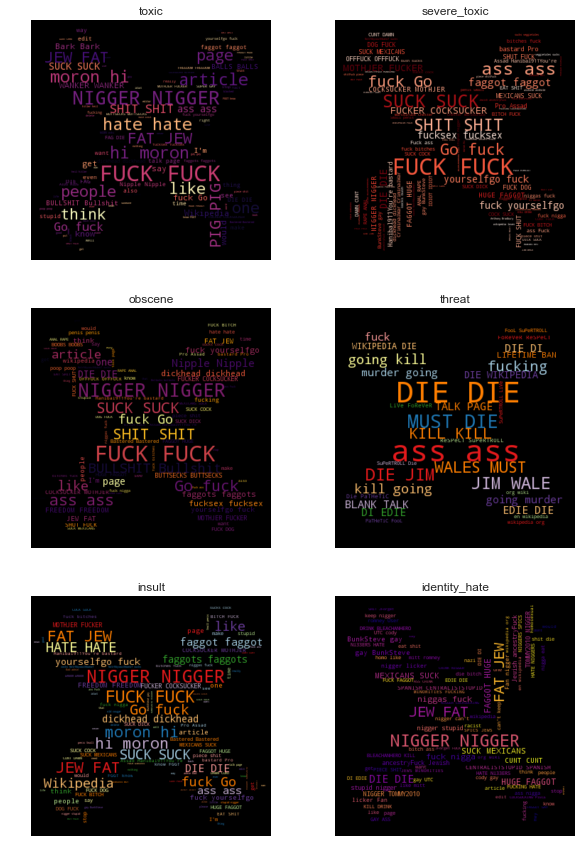

In [240]:
# wordcloud plot for subtypes of toxic comments
toxic_types = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
colormaps = ['magma', 'Reds', 'inferno', 'Paired_r', 'Paired_r', 'plasma']

plt.subplots(3,2, figsize=(10,15))
i = 1
for toxic_type, colormap in zip(toxic_types, colormaps):
    plt.subplot(3,2,i)
    wordcloud_toxic = wordcloud_generator(toxic_type,'black','image/mask_toxic.jpg')
    wordcloud_toxic_plot = plt.imshow(wordcloud_toxic.recolor(colormap = colormap, random_state = 29), interpolation = 'bilinear')
    plt.axis("off")
    plt.gca().set_title(toxic_type)
    i += 1
plt.show()

# save the figure
fig_wordcloud_toxic = wordcloud_toxic_plot.get_figure()
fig_wordcloud_toxic.savefig('figure/wordcloud_toxic.eps')

---
<a id='step2'></a>
## Step 2: Data Preprocessing


In [ ]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [ ]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [ ]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

The CNN are commonly made up of only three layer types: CONV, POOL(usually Max Pool) and FC(fully connected). The RELU activation function is usually applied to the CONV layer as elementwise non-linearity. 

Here, I have followed the most common form of a ConvNet architecture, which stacks a few CONV-RELU layers, follows them with POOL layers and Dropout layers, and repeats this pattern until the image has been merged spatially to a small size (28 by 28). The CONV-RELU layers apply a increasing number of small (3 by 3) filers, which contain non-linearities that make their features more expressive. The MaxPooling layers reduce the spatial size to the 1/4 of the previous layer every time applied. The Dropout layers help to prevent overfitting. 

At some point (here 28 by 28, not small enough), it is common to transition to fully-connected layers (Dense 512). The last fully connected layer connects to the output(Dense 133) corresponding to the 133 kinds of dogs.

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.initializers import VarianceScaling

model = Sequential()

initial = VarianceScaling(scale=2.0, mode='fan_in',distribution='normal',seed=100)

model.add(Conv2D(filters=16, kernel_size=3,kernel_initializer = initial, bias_initializer = 'zeros',
                 padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer = initial, bias_initializer = 'zeros',
                 padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=2, kernel_initializer = initial, bias_initializer = 'zeros',
                 padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,kernel_initializer = initial, bias_initializer = 'zeros', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(133, activation = 'softmax'))

model.summary()

### Compile the Model

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [ ]:
from keras.callbacks import ModelCheckpoint  

### specify the number of epochs that you would like to use to train the model.
epochs = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [ ]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [ ]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [ ]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture
The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

### Compile the Model

In [ ]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [ ]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [ ]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [ ]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

### Predict Dog Breed with the Model

In [ ]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [ ]:
### Obtain bottleneck features from another pre-trained CNN.
def load_bottleneck_features(filename):
    #load the bottleneck features
    bottleneck_features = np.load(filename)
    return bottleneck_features

#VGG19_bnf = load_bottleneck_features('bottleneck_features/DogVGG19Data.npz')
#ResNet50_bnf = load_bottleneck_features('bottleneck_features/DogResnet50Data.npz')
#Inception_bnf = load_bottleneck_features('bottleneck_features/DogInceptionV3Data.npz')
Xception_bnf = load_bottleneck_features('bottleneck_features/DogXceptionData.npz')

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

|bottleneck features|following layers|total parameters|accuracy|
|:----------:|:-------:|:----:|:----:|
|VGG-19|Dense(512), Dense(133)|330,885|73.3254%|
|ResNet50|Dense(512), Dense(133)|1,117,317|76.6746%|
|Inception|Dense(512), Dense(133)|1,117,317|78.3493%|
|Xception|Dense(512), Dense(133)|1,117,317|81.8182%|

As shown in the above table, I have tested four pre-trained models with similar architectures and Xception shows the best accuracy of 81%. 

As for the architecture, I added a GlobalAveragePooling layer first to minimize overfitting and to detect if a single feature exists. The output is 2048 then, if add a output layer directly, it reduces the nodes drastically and may lose some important information. So I add a Dense layer of 512 nodes with RELU activation, and then the output layer with 133 nodes correspoding to the total kinds of dogs. 

In [ ]:
### Define your architecture.
def create_model(bottleneck_features):
    model = Sequential()
    model.add(GlobalAveragePooling2D(input_shape = bottleneck_features['train'].shape[1:]))
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(133, activation = 'softmax'))
    model.summary()
    return model

#VGG19_model = create_model(VGG19_bnf)
#ResNet50_model = create_model(ResNet50_bnf)
#Inception_model = create_model(Inception_bnf)
Xception_model = create_model(Xception_bnf)

### (IMPLEMENTATION) Compile the Model

In [ ]:
### Compile the model.
def compile_model(model):
    model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
    return

#compile_model(VGG19_model)
#compile_model(ResNet50_model)
#compile_model(Inception_model)
compile_model(Xception_model)

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [ ]:
from keras.callbacks import ModelCheckpoint  
### Train the model.
def train_model(model, bottleneck_features, model_checkpoint_path, epochs = 20, batch_size = 20):
    checkpointer = ModelCheckpoint(filepath = model_checkpoint_path, 
                                   verbose = 1, save_best_only = True)
    
    model.fit(bottleneck_features['train'], train_targets,
              validation_data = (bottleneck_features['valid'], valid_targets),
              epochs = epochs, batch_size = batch_size, callbacks = [checkpointer], verbose = 1) 

#train_model(VGG19_model, VGG19_bnf, 'saved_models/weights.best.VGG19.hdf5')
#train_model(ResNet50_model, ResNet50_bnf, 'saved_models/weights.best.ResNet50.hdf5')
#train_model(Inception_model, Inception_bnf, 'saved_models/weights.best.Inception.hdf5')
train_model(Xception_model, Xception_bnf, 'saved_models/weights.best.Xception.hdf5')

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [ ]:
### Load the model weights with the best validation loss.
def load_weights(model, model_checkpoint_path):
    model.load_weights(model_checkpoint_path)
    return

#load_weights(VGG19_model, 'saved_models/weights.best.VGG19.hdf5')
#load_weights(ResNet50_model, 'saved_models/weights.best.ResNet50.hdf5')
#load_weights(Inception_model, 'saved_models/weights.best.Inception.hdf5')
load_weights(Xception_model, 'saved_models/weights.best.Xception.hdf5')


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [ ]:
### Calculate classification accuracy on the test dataset.
def model_accuracy(model, bottleneck_features):
    #get index of predicted dog breed for each image in test set
    model_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in bottleneck_features['test']]
    # report test accuracy
    test_accuracy = 100*np.sum(np.array(model_predictions)==np.argmax(test_targets, axis=1))/len(model_predictions)
    print('Test accuracy: %.4f%%' % test_accuracy)
    
#model_accuracy(VGG19_model, VGG19_bnf)
#model_accuracy(ResNet50_model, ResNet50_bnf)
#model_accuracy(Inception_model, Inception_bnf)
model_accuracy(Xception_model, Xception_bnf)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [ ]:
### Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the Xception model.
from extract_bottleneck_features import extract_Xception
def Xception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Xception_model.predict(bottleneck_feature)
    # return dog breed that is predicted by Xception model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm



---
<a id='step7'></a>
## Step 7: Test Your Algorithm

However, it still needs improvement as it misidentified the my neighbour's dog Bandit as "Chesapeake bay retriever" while he is "Labrador retriever", partially because the image is blurred. 

The possible improvements would be:
 - Add dropout layers to reduce overfitting
 - Gridsearch for fine hyperparameter tuning
 - Augmentation